# Logistic Regression for Player Position Prediction
## Overview
This notebook implements Logistic Regression to predict player position based on their statistics

## To-Do list
0. Imports
1. Frame the Problem
2. Data Exploration
3. Preprocessing and Feature Selection
4. Model Development
5. Final Evaluation
6. Summary Table
7. Conclusion and Analysis



# 0. Imports
Before we go over the model These are the inputs we need for the Logistic Regression:

In [218]:
import pandas as pd
from sklearn.model_selection import train_test_split # to split training and testing
from sklearn.linear_model import LogisticRegression # To calculate the w value and bias
from sklearn.metrics import accuracy_score # Later to calculate prediction and accuracy
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif



# 1. Frame the Problem
This project aims to predict the position of NBA players based on their in-game performance statistics. We treat this as a supervised multiclass classification problem using Logistic Regression
## The Inputs and Outputs
### Inputs (Features):
We use multiple numerical features that reflect each player’s in-game activity, such as: 
`Minutes played` (MIN), `Points scored (PTS)`, `Rebounds (REB)`, `Assists (AST)`, `Steals (STL)`, `Blocks (BLK)`, and include `Field goals`, `turnover`, `heights`, etc. These features are extracted from the Kaggle dataset titled "NBA Player Stats by Season", which contains per-season statistics for professional players across multiple years.



In [219]:
season_stats = pd.read_csv("players_stats_by_season_with_position.csv")

X = season_stats[[ "GP", "MIN", "FGM", "FGA", "3PM", "3PA", "FTM", "FTA", 
                "TOV", "PF", "ORB", "REB", "AST", "STL", "BLK", "PTS",
                "height_cm", "weight_kg"]]

### Outputs (Target):
The output label is the player's general postion category. The dataset originally included overlapping or mixed roles (3.g., Guard-Forward), so we consolidated positions into 5 distinct classes:

| Position Label | Meaning                        |
|----------------|--------------------------------|
| 1              | Guard                          |
| 2             | Guard-Forward / Forward-Guard  |
| 3              | Forward                        |
| 4              | Forward-Center / Center-Forward|
| 5              | Center                         |

We use these class numbers as the target variable for classificaton

In [220]:
y = season_stats["position_number"].astype(str) 

## Evaluation Metric
We primarily evaluate model performance using accuracy

## Limitation
One limitation of the dataset is that it does not distinguish between fine-grained roles like point guards vs. shooting guard, or power forward vs. small forward. As a result, some hybrid roles were grouped together into generalized labels (e.g., Guard-Forward)


# 2. Data Exploration

## Basic Statistic

### .shape

In [221]:
print(season_stats.shape)      

(1662, 36)


The dataset contains 1,662 rows and 36 columns.
Each row represents a single player's performance in a specific NBA season.
However, not all columns are relevant for modeling; for example, non-numeric columns such as birth_date or player name will be excluded during preprocessing.

### .info()

In [222]:
print(season_stats.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1662 entries, 0 to 1661
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   League           1662 non-null   object 
 1   Season           1662 non-null   object 
 2   Stage            1662 non-null   object 
 3   Player           1662 non-null   object 
 4   Team             1662 non-null   object 
 5   GP               1662 non-null   int64  
 6   MIN              1662 non-null   float64
 7   FGM              1662 non-null   int64  
 8   FGA              1662 non-null   int64  
 9   3PM              1662 non-null   int64  
 10  3PA              1662 non-null   int64  
 11  FTM              1662 non-null   int64  
 12  FTA              1662 non-null   int64  
 13  TOV              1662 non-null   int64  
 14  PF               1662 non-null   int64  
 15  ORB              1662 non-null   int64  
 16  DRB              1662 non-null   int64  
 17  REB           

The dataset contains 36 columns, including both numerical and categorical features.
All of the columns we plan to use as input features are complete and contain no missing values.

### .describe()

In [223]:
print(season_stats.describe())    

                GP          MIN          FGM          FGA          3PM  \
count  1662.000000  1662.000000  1662.000000  1662.000000  1662.000000   
mean     48.961492  1382.705957   243.654031   522.178700    56.600481   
std      30.631204   950.609622   199.146049   422.891977    62.300396   
min       3.000000    60.300000     3.000000     7.000000     0.000000   
25%      13.000000   368.125000    57.000000   120.250000     6.000000   
50%      64.000000  1480.100000   210.000000   445.500000    33.000000   
75%      77.000000  2193.250000   378.000000   804.500000    92.000000   
max      82.000000  3388.000000   875.000000  1941.000000   402.000000   

               3PA          FTM          FTA          TOV           PF  ...  \
count  1662.000000  1662.000000  1662.000000  1662.000000  1662.000000  ...   
mean    156.409747   120.516245   155.776775    84.247894   108.652226  ...   
std     163.493531   125.627712   156.234588    73.994752    74.433785  ...   
min       0.00000

## Data Visualization

### Target class distribution

position_number
1    633
3    473
4    203
2    189
5    164
Name: count, dtype: int64


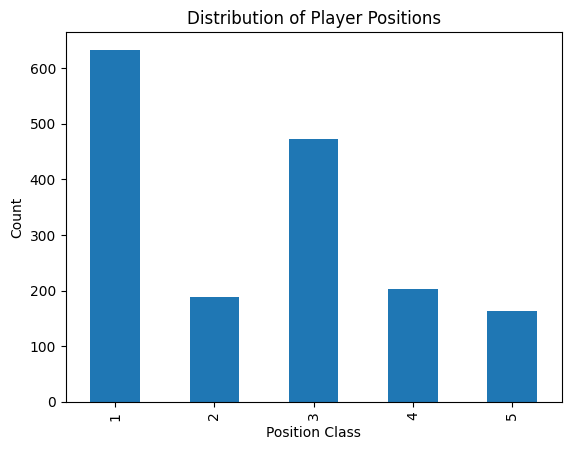

In [224]:
season_stats_number = season_stats["position_number"].value_counts()
print(season_stats_number)
season_stats["position_number"].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Player Positions")
plt.xlabel("Position Class")
plt.ylabel("Count")
plt.show()


The class distribution is moderately imbalanced.
Class 1 (Guard) has the largest number of samples (633), followed by Class 3 (Forward) with 473.
Classes 2, 4, and 5 have significantly fewer samples, with Class 5 (Center) being the smallest group at 164.
This imbalance may affect classification performance, especially for minority classes.

### Heatmaps

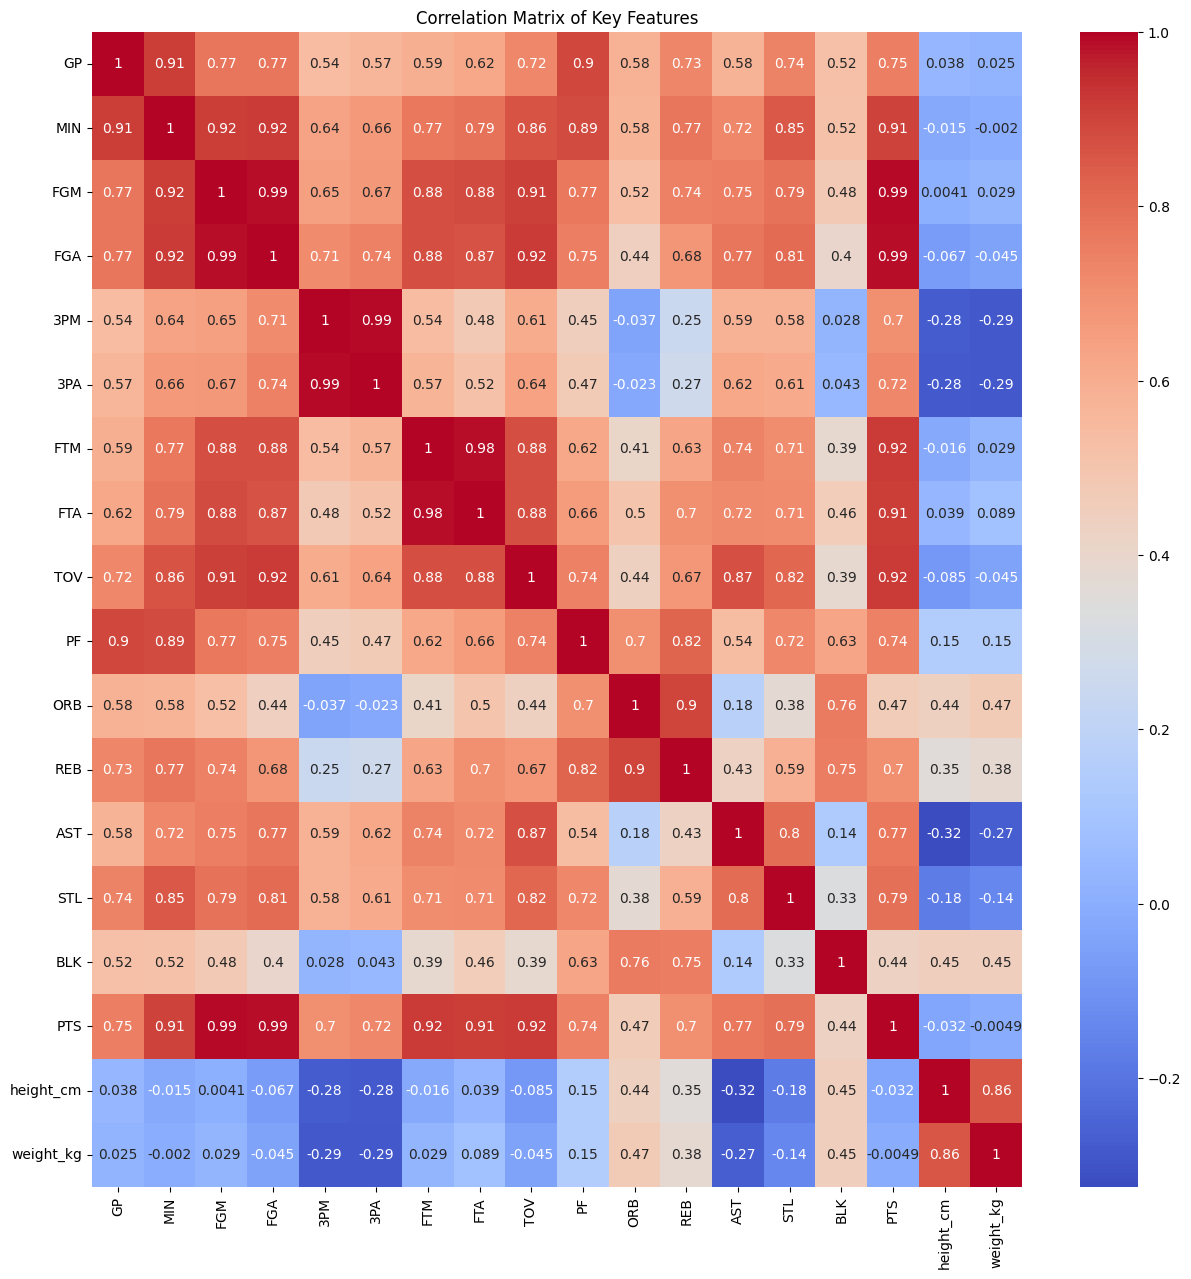

In [225]:
features = [ "GP", "MIN", "FGM", "FGA", "3PM", "3PA", "FTM", "FTA", 
                "TOV", "PF", "ORB", "REB", "AST", "STL", "BLK", "PTS",
                "height_cm", "weight_kg"]
corr = season_stats[features].corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Key Features")
plt.show()


The correlation matrix reveals several strong linear relationships among the features.
As expected, `MIN`, `FGM`, and `PTS` are highly correlated (ρ ≈ 0.99), indicating that players who play more tend to score more.
Free throw-related features (`FTM`, `FTA`) also show strong internal correlation.
Meanwhile, height and weight show weak or negative correlations with most performance metrics, suggesting they are less predictive in this context.

### Histogram

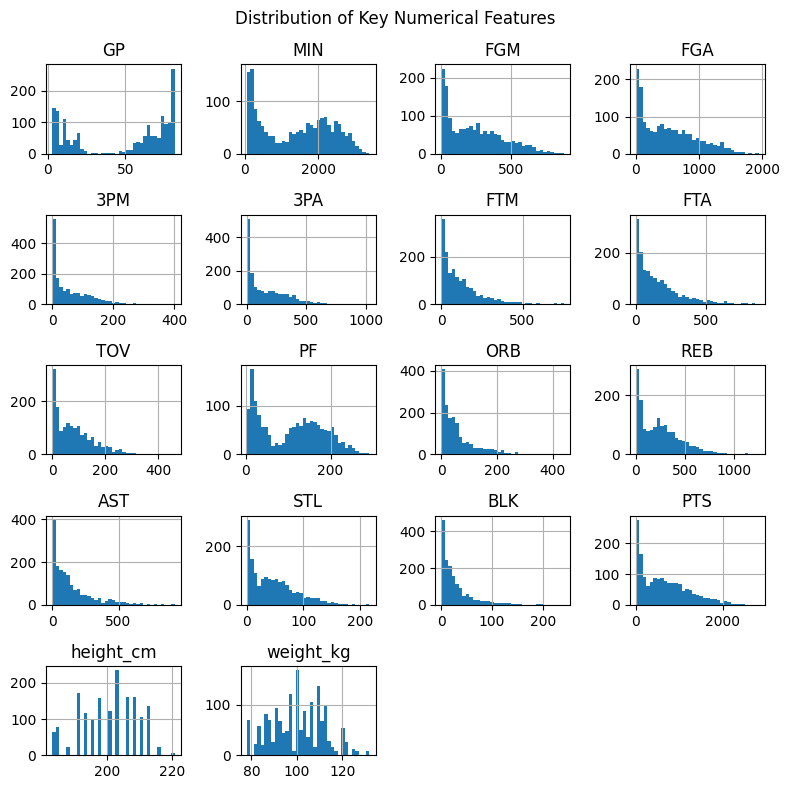

In [226]:
features = [ "GP", "MIN", "FGM", "FGA", "3PM", "3PA", "FTM", "FTA", 
                "TOV", "PF", "ORB", "REB", "AST", "STL", "BLK", "PTS",
                "height_cm", "weight_kg"]

season_stats[features].hist(bins=35, figsize=(8, 8))
plt.suptitle("Distribution of Key Numerical Features", fontsize=12)
plt.tight_layout()
plt.show()


The histograms of the numerical features show that most variables are right-skewed, with a majority of values clustered toward the lower end.
For example, features like `FTA` , `REB`, and `AST` are heavily concentrated near zero, with a few extreme values (outliers) on the higher end.
This indicates that the dataset contains a mix of typical and high-performing players, and that feature scaling will be important during preprocessing.
In contrast, features like height_cm and weight_kg exhibit more normally distributed patterns, with values centered around the mean.

### PCA

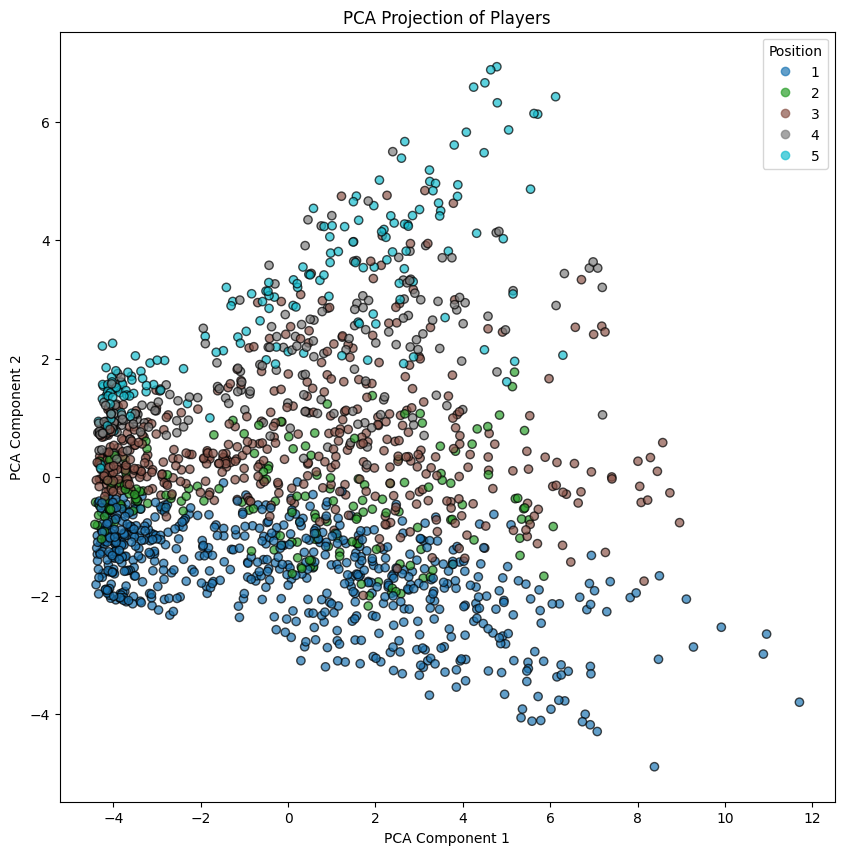

In [227]:
# Features (inputs)
features = [ "GP", "MIN", "FGM", "FGA", "3PM", "3PA", "FTM", "FTA", 
                "TOV", "PF", "ORB", "REB", "AST", "STL", "BLK", "PTS",
                "height_cm", "weight_kg"]
X = season_stats[features]
y = season_stats['position_number'].astype(int)

# Scalling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize
plt.figure(figsize=(10, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7, edgecolor='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Players")
plt.legend(*scatter.legend_elements(), title="Position")
plt.show()


We applied PCA to project 18-dimensional player features into 2D for visualization.
While classes overlap, some separation is visible, especially for Positions 1 and 5.
This indicates that certain roles exhibit distinct statistical patterns, justifying the use of supervised learning.

# 3. Preprocess and Feature Selection


## Preprocessing

### Remove Features

In [228]:
selected_features = [ "GP", "MIN", "FGM", "FGA", "3PM", "3PA", "FTM", "FTA", 
                      "TOV", "PF", "ORB", "REB", "AST", "STL", "BLK", "PTS",
                      "height_cm", "weight_kg" ]
season_stats = season_stats[selected_features + ['position_number']]

Because `draft team`, `draft pick`, `draft round`, `highschool`, `birthday` etc would not effect on getting the output, we can remove those features.

### Erase Outliers

In [229]:
season_stats = season_stats[season_stats['GP'] > 65]

We removed players who played fewer than 65 games, as they may be bench players or injured, which can introduce noise and reduce model accuracy.

### Train and Test Split

In [230]:
X = season_stats.drop("position_number", axis=1) # Exclude the y values
y = season_stats["position_number"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(season_stats.count()) 

GP                 784
MIN                784
FGM                784
FGA                784
3PM                784
3PA                784
FTM                784
FTA                784
TOV                784
PF                 784
ORB                784
REB                784
AST                784
STL                784
BLK                784
PTS                784
height_cm          784
weight_kg          784
position_number    784
dtype: int64


We split the data into 80% for training and 20% for testing. This means 627 is going to be used as training and rest of them would be used as testing  
`random_state` ensures reproducibility, and `stratify=y` guarantees that the class distribution in `position_number` is preserved in both sets.


### Normalize


In [231]:
# Define the scaler
scaler = StandardScaler()
# Transforms after it calculates the average and SD
X_train_scaled = scaler.fit_transform(X_train)

# Only transforms using scale from train data
X_test_scaled = scaler.transform(X_test)


We standardized the feature values using StandardScaler, which transforms the features to have zero mean and unit variance. This ensures that features with larger scales (e.g., minutes played or points scored) do not dominate those with smaller scales (e.g., blocks or steals).
The scaler was fitted on the training data only to prevent data leakage, and the same scaling was then applied to the test set.


## Feature Selection

### Polynomial Features

In [232]:
# Creates a polynomial
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
# show all the features 
print(poly.get_feature_names_out())
print(X_train_poly.shape)  

['x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12' 'x13'
 'x14' 'x15' 'x16' 'x17' 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x0 x4' 'x0 x5'
 'x0 x6' 'x0 x7' 'x0 x8' 'x0 x9' 'x0 x10' 'x0 x11' 'x0 x12' 'x0 x13'
 'x0 x14' 'x0 x15' 'x0 x16' 'x0 x17' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4'
 'x1 x5' 'x1 x6' 'x1 x7' 'x1 x8' 'x1 x9' 'x1 x10' 'x1 x11' 'x1 x12'
 'x1 x13' 'x1 x14' 'x1 x15' 'x1 x16' 'x1 x17' 'x2^2' 'x2 x3' 'x2 x4'
 'x2 x5' 'x2 x6' 'x2 x7' 'x2 x8' 'x2 x9' 'x2 x10' 'x2 x11' 'x2 x12'
 'x2 x13' 'x2 x14' 'x2 x15' 'x2 x16' 'x2 x17' 'x3^2' 'x3 x4' 'x3 x5'
 'x3 x6' 'x3 x7' 'x3 x8' 'x3 x9' 'x3 x10' 'x3 x11' 'x3 x12' 'x3 x13'
 'x3 x14' 'x3 x15' 'x3 x16' 'x3 x17' 'x4^2' 'x4 x5' 'x4 x6' 'x4 x7'
 'x4 x8' 'x4 x9' 'x4 x10' 'x4 x11' 'x4 x12' 'x4 x13' 'x4 x14' 'x4 x15'
 'x4 x16' 'x4 x17' 'x5^2' 'x5 x6' 'x5 x7' 'x5 x8' 'x5 x9' 'x5 x10'
 'x5 x11' 'x5 x12' 'x5 x13' 'x5 x14' 'x5 x15' 'x5 x16' 'x5 x17' 'x6^2'
 'x6 x7' 'x6 x8' 'x6 x9' 'x6 x10' 'x6 x11' 'x6 x12' 'x6 x13' 'x6 x14'
 'x6 x15' 'x6 x16' 'x6 x17

To help a linear model capture non-linear relationships between features, we applied a 2nd-degree polynomial feature transformation. This expands the original features by adding their squares and pairwise interactions (e.g., x1^2, x1·x2, ...), enabling a linear model like Logistic Regression to approximate more complex, non-linear decision boundaries.
After the transformation:
- The number of input features increased from 18 to 189.

- The model can now learn from not only individual features but also their interactions.

- This is especially useful when the original data is not linearly separable in the original feature space.

### PCA

In [233]:
pca = PCA(n_components=10)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("Original shape:", X_train_scaled.shape)
print("PCA-transformed shape:", X_train_pca.shape)


Original shape: (627, 18)
PCA-transformed shape: (627, 10)


We applied PCA to reduce the original 18-dimensional input into 10 principal components.
PCA captures the directions of maximum variance in the data, allowing the model to focus on the most informative patterns while discarding noise or redundant dimensions. This not only improves computational efficiency but also helps reduce overfitting risk.

### SelectKBest

In [234]:
selector = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = selector.fit_transform(X_train_scaled, y_train)
X_test_kbest = selector.transform(X_test_scaled)
selected = selector.get_support(indices=True)
selected_features = X_train.columns[selected]
print("Selected Features: \n", selected_features)

Selected Features: 
 Index(['3PM', '3PA', 'PF', 'ORB', 'REB', 'AST', 'STL', 'BLK', 'height_cm',
       'weight_kg'],
      dtype='object')


We applied SelectKBest to reduce the original 18-dimensional input into the 10 most statistically relevant features. The chosen features are: `3PM`, `3PA`, `PF`, `ORB`, `REB`, `AST`, `STL`, `BLK`, `height_cm`,
       `weight_kg`

# 4. Model Development

## Training and Test Accuracy

In [235]:
model = LogisticRegression(
    C=1.0,
    penalty='elasticnet',
    l1_ratio=0.5,
    solver='saga', 
    max_iter=10000
)
model.fit(X_train_scaled, y_train)

print("Training Accuracy: ",model.score(X_train_scaled, y_train))
print("Testing Accuracy: ",model.score(X_test_scaled, y_test))

                    

Training Accuracy:  0.8245614035087719
Testing Accuracy:  0.821656050955414


## Hyperparameter Tuining (Training Cases)


In [236]:
# PCA
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
for c in C_values:
    model.fit(X_train_pca, y_train) 
    train_acc = model.score(X_train_pca, y_train)
    print(f"C={c}: Train: {train_acc:.4f}")


C=0.001: Train: 0.7943
C=0.01: Train: 0.7943
C=0.1: Train: 0.7943
C=1: Train: 0.7943
C=10: Train: 0.7943
C=100: Train: 0.7943


In [247]:
# Polynomial
for c in C_values:
    model.fit(X_train_poly, y_train) 
    train_acc = model.score(X_train_poly, y_train)
    print(f"C={c}: Train: {train_acc:.4f}")


C=0.001: Train: 0.9522
C=0.01: Train: 0.9522
C=0.1: Train: 0.9522
C=1: Train: 0.9522
C=10: Train: 0.9522
C=100: Train: 0.9522


In [248]:
# Select K best
for c in C_values:
    model.fit(X_train_kbest, y_train) 
    train_acc = model.score(X_train_kbest, y_train)
    print(f"C={c}: Train: {train_acc:.4f}")

    

C=0.001: Train: 0.8118
C=0.01: Train: 0.8118
C=0.1: Train: 0.8118
C=1: Train: 0.8118
C=10: Train: 0.8118
C=100: Train: 0.8118


From the data, we can observe that the polynomial transformation results in the highest training accuracy among all feature transformation methods.

## Hyperparameter Tuining (Test Cases)


In [203]:
# PCA
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
for c in C_values:
    model.fit(X_train_pca, y_train) 
    test_acc = model.score(X_test_pca, y_test)
    print(f"C={c}: Test: {test_acc:.4f}")


C=0.001: Test: 0.8153
C=0.01: Test: 0.8153
C=0.1: Test: 0.8153
C=1: Test: 0.8153
C=10: Test: 0.8153
C=100: Test: 0.8153


In [204]:
# Polynomial
for c in C_values:
    model.fit(X_train_poly,y_train)
    test_acc = model.score(X_test_poly, y_test)
    print(f"C={c}: Test: {test_acc:.4f}")


C=0.001: Test: 0.8408
C=0.01: Test: 0.8408
C=0.1: Test: 0.8408
C=1: Test: 0.8408
C=10: Test: 0.8408
C=100: Test: 0.8408


In [205]:
# Select K best
for c in C_values:
    model.fit(X_train_kbest,y_train) #학습
    test_acc = model.score(X_test_kbest, y_test)
    print(f"C={c}: Test: {test_acc:.4f}")

    

C=0.001: Test: 0.8089
C=0.01: Test: 0.8089
C=0.1: Test: 0.8089
C=1: Test: 0.8089
C=10: Test: 0.8089
C=100: Test: 0.8089


From the data, we observe that the polynomial transformation achieves the highest training and test accuracy among all feature transformation methods. Therefore, we will use the polynomial features for final model evaluation.

# 5. Final Evaluation

## Confusion Matrix

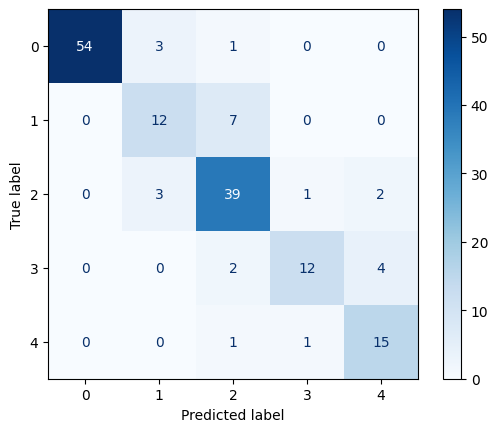

In [250]:
model.fit(X_train_poly,y_train)
y_pred=model.predict(X_test_poly)

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  

## Precision, Recall, F1-score per Class

In [251]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.93      0.96        58
           2       0.67      0.63      0.65        19
           3       0.78      0.87      0.82        45
           4       0.86      0.67      0.75        18
           5       0.71      0.88      0.79        17

    accuracy                           0.84       157
   macro avg       0.80      0.80      0.79       157
weighted avg       0.85      0.84      0.84       157



## Accuracy 

In [252]:
print("Final Test Accuracy:", accuracy_score(y_test, y_pred))

Final Test Accuracy: 0.8407643312101911
